In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy
import anndata


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

sc.set_figure_params(figsize=(4, 4))

palette = ['#fbbc04', '#199de5', '#cfe6d5']

sc.settings.figdir = './figures_somatic/'

In [2]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig('barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

# Somatic cells

In [3]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
adata = sc.read(path_to_gonads + 'mouse-gonads_somatic.h5ad')

In [ ]:
adata.obs['location'] = adata.obs['location'].tolist()
adata.obs.at[adata.obs['dataset'] == 'Niu2020', 'location'] = 'gonadal_and_extragonadal'

In [4]:
adata.obs['celltype'].values.describe()

counts     freqs
categories                             
CoelEpi_Gata2            6143  0.117727
CoelEpi_Gata2_cycling     424  0.008126
CoelEpi_Lhx9             6632  0.127099
early_supporting         4072  0.078038
sPAX8                    1689  0.032369
preGC_I                  4719  0.090437
OSE                      1031  0.019759
preGC_II                 7556  0.144806
granulosa                1919  0.036777
Sertoli                  1516  0.029053
Gi                       5836  0.111844
Oi                       7649  0.146589
Ti                       2019  0.038693
FetalLeydig               199  0.003814
Doublet                    34  0.000652
lowQC                     523  0.010023
cont                      219  0.004197

In [5]:
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.lineage]]
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.celltype]]
adata = adata[[not i for i in adata.obs.is_doublet]]

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Trying to set attribute `.uns` of view, copying.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


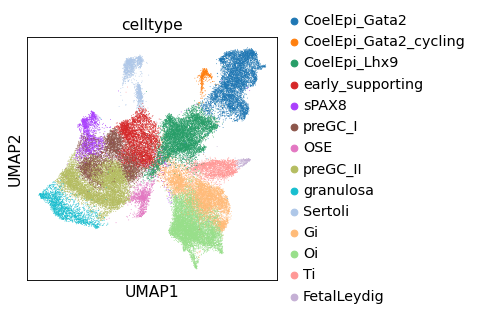

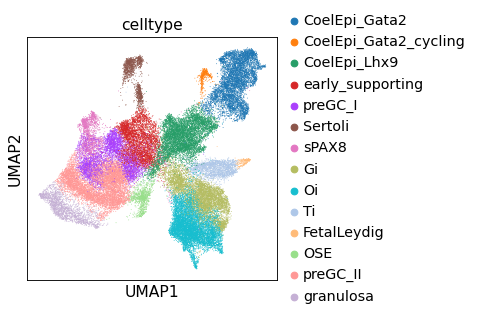

In [6]:
sc.pl.umap(adata, color=['celltype'])
adata.obs['celltype'].cat.reorder_categories(['CoelEpi_Gata2',  'CoelEpi_Gata2_cycling',  'CoelEpi_Lhx9',
                                              'early_supporting', 'preGC_I',  'Sertoli',  
                                              'sPAX8', 'Gi','Oi', 'Ti', 'FetalLeydig',
                                              'OSE', 'preGC_II', 'granulosa'], inplace=True)
sc.pl.umap(adata, color=['celltype'])

# Plot umap

In [7]:
colorsSom_df = pd.read_csv('gonads_somatic_colors_mouse.csv',index_col=0)
colorsSom_df
idx = [colorsSom_df.index.tolist().index(i) for i in adata.obs['celltype'].cat.categories.tolist() ]
adata.uns['celltype_colors'] = [ colorsSom_df.color[i] for i in idx ]


label_annot = colorsSom_df['label'].to_dict()
adata.obs['labels'] = adata.obs['celltype'].map(label_annot)

colorsSom_df = colorsSom_df.set_index('label')
label2color_annot = colorsSom_df['color'].to_dict()
from natsort import natsorted
x = natsorted(list(set(adata.obs['labels'])))
adata.uns['labels_colors'] = [ label2color_annot[i] for i in  x ]

In [8]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 50933
Total number of genes: 24215


... storing 'labels' as categorical
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


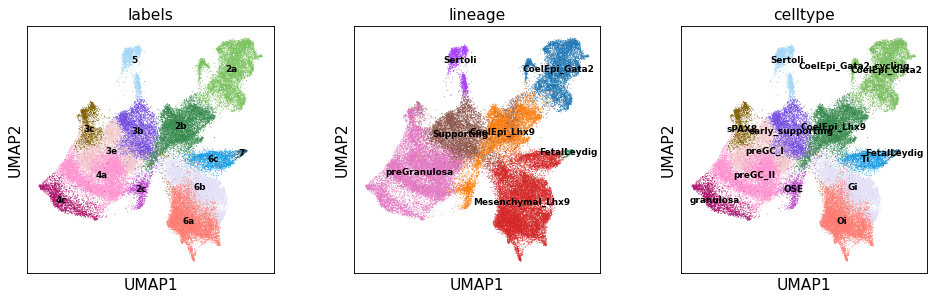

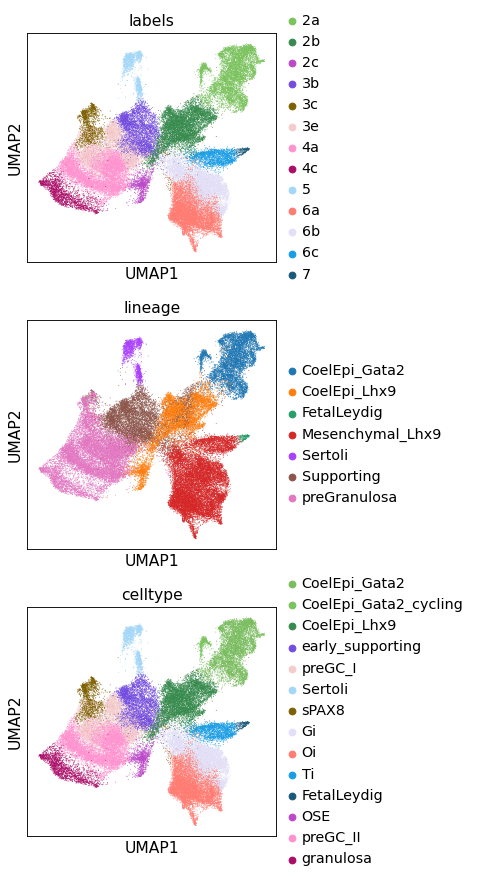

In [9]:
# plt.rcParams['figure.figsize'] = (4,4)
sc.pl.umap(adata, color=['labels', 'lineage', 'celltype'], legend_loc='on data', legend_fontsize=8, save='_mouse_somatic_labelsON.pdf')


with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(adata, color=['labels', 'lineage', 'celltype'], ncols=1, save='_mouse_somatic_legend.pdf')

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'sample' as categorical
... storing 'location' as categorical
... storing 'sex_celltype' as categorical


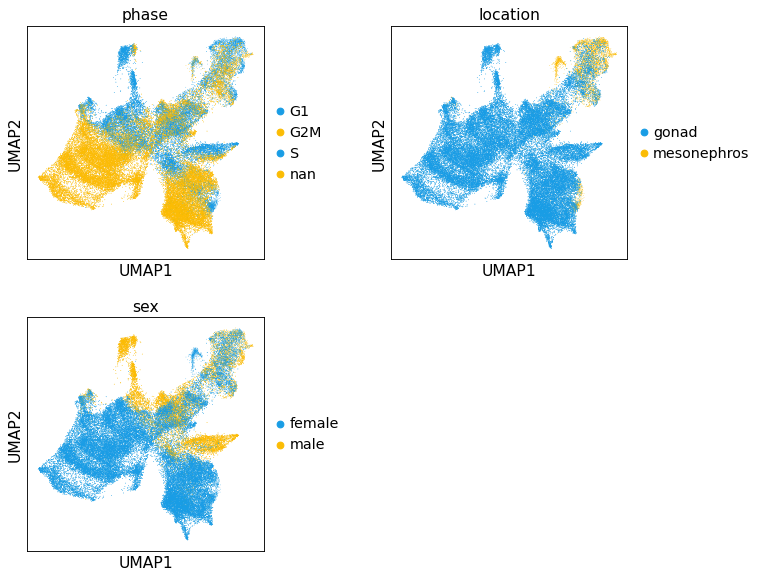

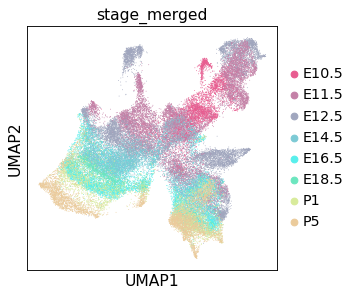

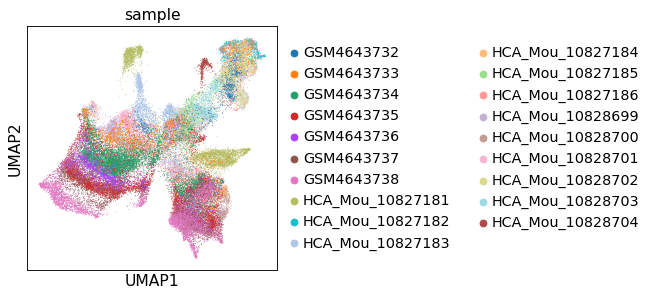

In [35]:
X_last = adata[[ i in 'gonadal_and_extragonadal' for i in adata.obs.location ]]
X_first = adata[[ 'gonadal_and_extragonadal' not in i for i in adata.obs.location ]]
X_resorted = X_first.concatenate(X_last)

with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
    X_resorted,
    color=['phase', 'location',  'sex'], palette=palette,
    frameon=True, ncols = 2, wspace = 0.4, save='_somatic_metadata_I.pdf'
)

pal_stage_merged = ['#E85C90', '#C481A7','#A0A6BE','#7CCAD5','#58EFEC','#6ce6bf', '#d8eb9b', '#ebcb9b']
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(
        adata,
        color=["stage_merged"], palette=pal_stage_merged,
        frameon=True, ncols = 2, wspace = 0.3, save='_somatic_metadata_II.pdf'
    )
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(
        adata,
        color=["sample"],
        frameon=True, ncols = 2, wspace = 0.3, save='_somatic_metadata_III.pdf'
    )

# Visualize markers

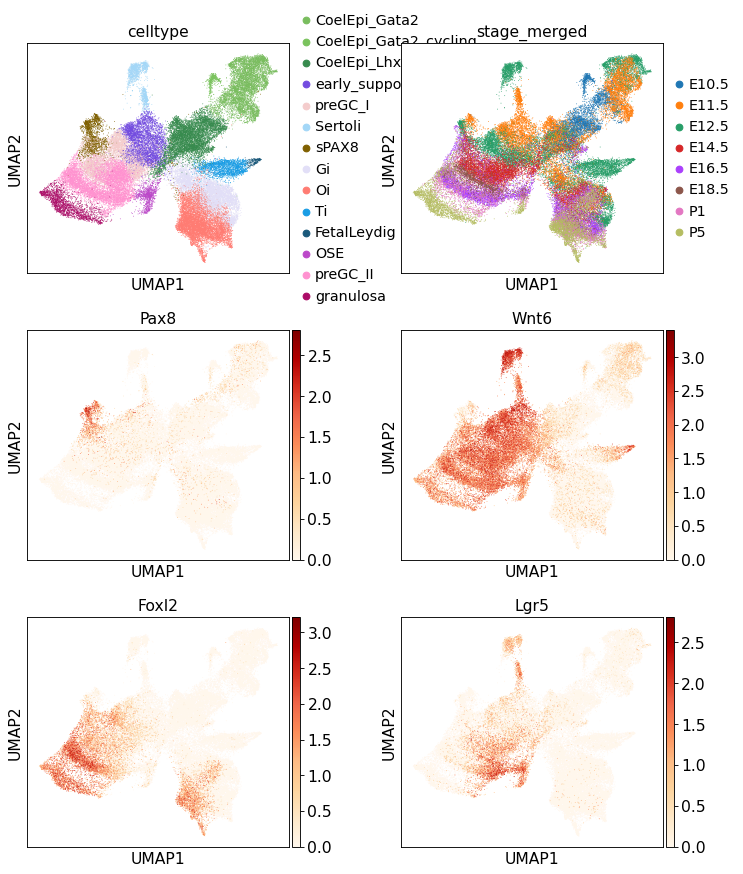

In [10]:
sc.pl.umap(
    adata,
    color=['celltype', 'stage_merged' , 'Pax8','Wnt6', 'Foxl2', 'Lgr5'], color_map = "OrRd",
    frameon=True, ncols = 2, wspace = 0.3
)

# sc.pl.dotplot(adata, ['Hmcn1', 'Sp5', 'Cst12'], groupby='celltype', standard_scale = 'var')

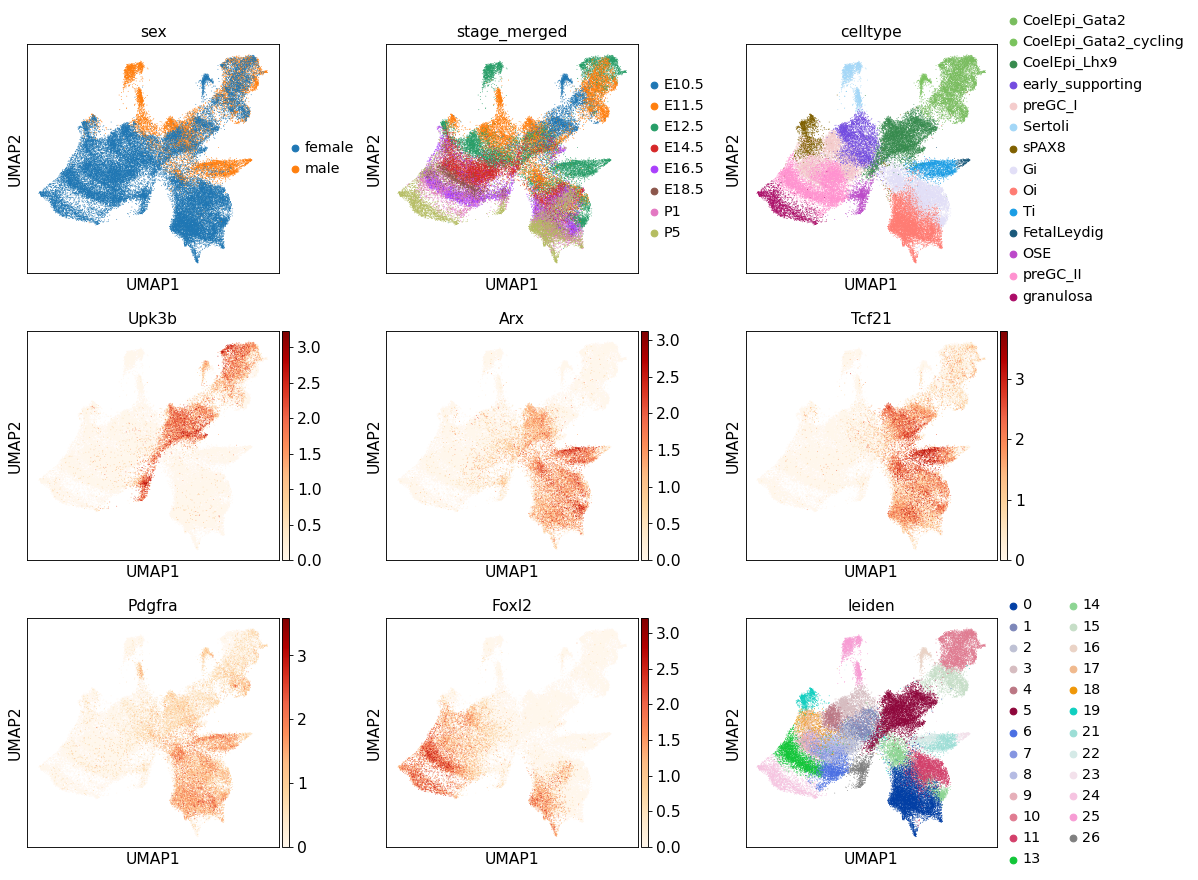

In [12]:
sc.pl.umap(
    adata,
    color=['sex', 'stage_merged', 'celltype', 'Upk3b', 'Arx', 'Tcf21', 'Pdgfra', 'Foxl2','leiden'], color_map = "OrRd",
    frameon=True, ncols = 3, wspace = 0.3
)

In [47]:
markers_mmu = ['Nr2f2', 'Foxl2', 'Lgr5', 'Pax8', 'Hsd17b1', 'Bmp2' , 'Gng13','Hmgcs2', 'Znrf3', 'Col12a1', 'Upk3b', 'Tm4sf5', 'Col1a2', 'Gas1', 'Hs6st1', 'Gadd45g', 'Cpa2', 'Irx3', 'Itga8', 'Col6a3', 'Ttc38', 'Itga6', 'Ereg', 'Fndc5']

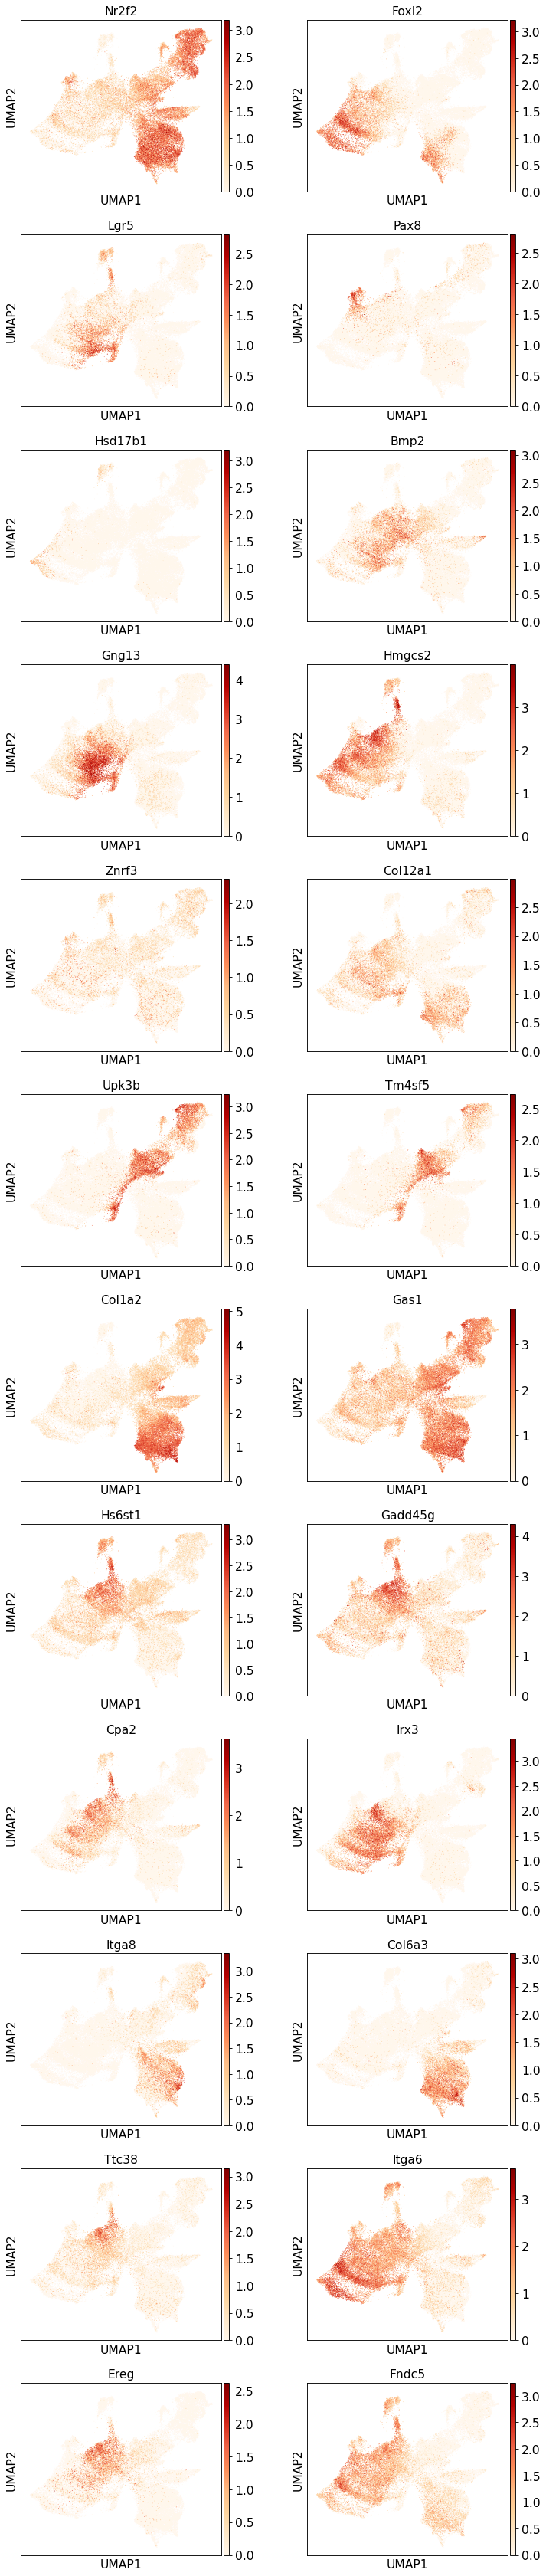

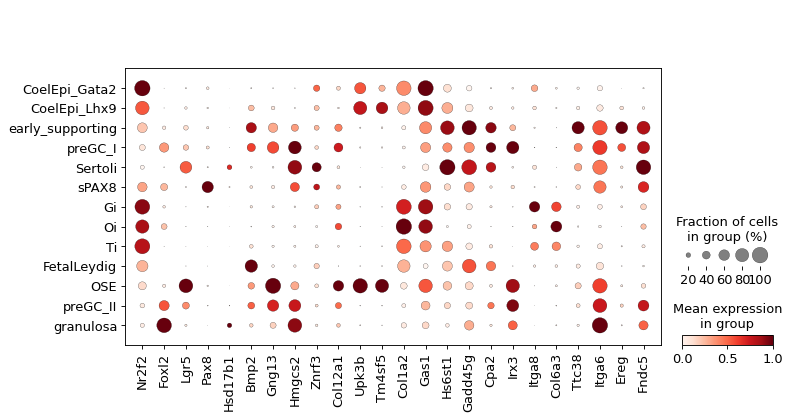

In [48]:
sc.pl.umap(
    adata,
    color=markers_mmu, color_map = "OrRd",
    frameon=True, ncols = 2, wspace = 0.3
)
sc.pl.dotplot(adata, markers_mmu, groupby='celltype', standard_scale = 'var')

# PLOT 1st wave

... storing 'celltype' as categorical


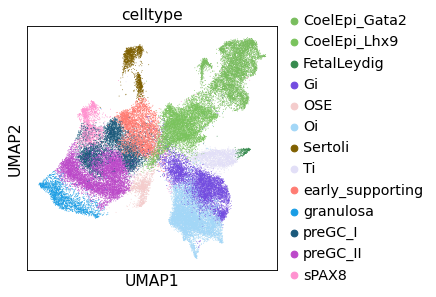

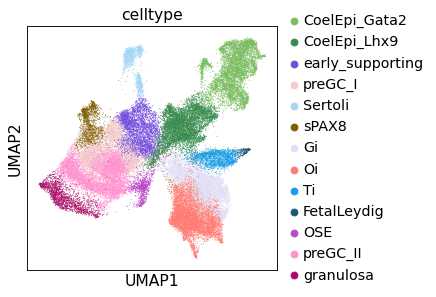

In [15]:
# Merge coel epitheliums Lhx9 for simplicity
adata.obs['celltype'] = adata.obs['celltype'].tolist()
adata.obs['celltype'] = [ i.replace('_cycling', '') for i in adata.obs['celltype'] ]
sc.pl.umap(adata, color=['celltype'])
adata.obs['celltype'].cat.reorder_categories(['CoelEpi_Gata2',   'CoelEpi_Lhx9', 
                                              'early_supporting', 'preGC_I',  'Sertoli',  
                                              'sPAX8', 'Gi','Oi', 'Ti', 'FetalLeydig',
                                              'OSE', 'preGC_II', 'granulosa'], inplace=True)
colorsSom_df = pd.read_csv('gonads_somatic_colors_mouse.csv',index_col=0)
colorsSom_df
idx = [colorsSom_df.index.tolist().index(i) for i in adata.obs['celltype'].cat.categories.tolist() ]
adata.uns['celltype_colors'] = [ colorsSom_df.color[i] for i in idx ]
sc.pl.umap(adata, color=['celltype'])

In [16]:
adata.obs['celltype2'] = adata.obs['celltype'].tolist()

mask1 = np.array([i in 'early_supporting' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'early_supporting_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'early_supporting_male'

... storing 'celltype2' as categorical


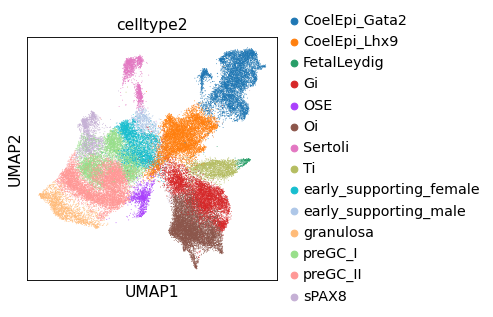

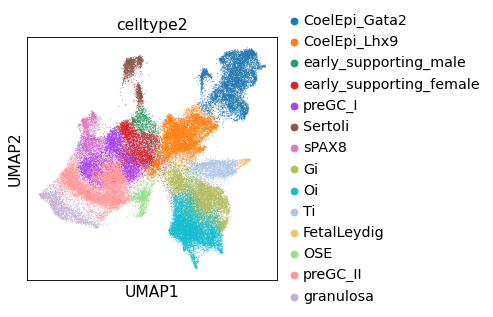

In [17]:
sc.pl.umap(adata, color=['celltype2'])
adata.obs['celltype2'].cat.reorder_categories(['CoelEpi_Gata2',   'CoelEpi_Lhx9', 
                                              'early_supporting_male', 'early_supporting_female', 'preGC_I',  'Sertoli',  
                                              'sPAX8', 'Gi','Oi', 'Ti', 'FetalLeydig',
                                              'OSE', 'preGC_II', 'granulosa'], inplace=True)
sc.pl.umap(adata, color=['celltype2'])

In [ ]:
# X_last = X[[ i in 'Gonad_and_extragonadal' for i in X.obs.location ]]
# X_first = X[[ 'Gonad_and_extragonadal' not in i for i in X.obs.location ]]
# X_resorted = X_first.concatenate(X_last)

with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
    X_resorted,
    color=['phase', 'location',  'stage_merged'], palette=palette,
    frameon=True, ncols = 2, wspace = 0.4, save='_somatic_metadata_I.pdf'
)
with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
        X,
        color=["PCW"], cmap='Spectral',
        frameon=True, ncols = 2, wspace = 0.3, save='_somatic_metadata_II.pdf'
    )
with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(
        X,
        color=["donor"],
        frameon=True, ncols = 2, wspace = 0.3, save='_somatic_metadata_III.pdf'
    )

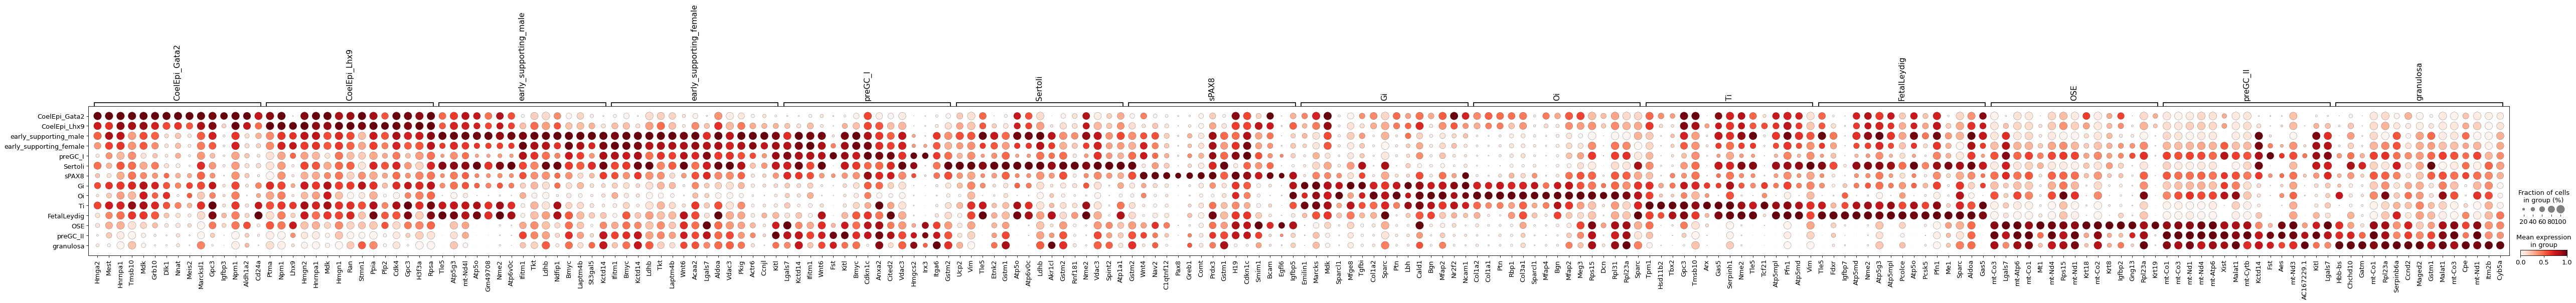

In [18]:
sc.tl.rank_genes_groups(adata, groupby='celltype2', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(adata, n_genes=15, dendrogram=False, use_raw = False, standard_scale = 'var')

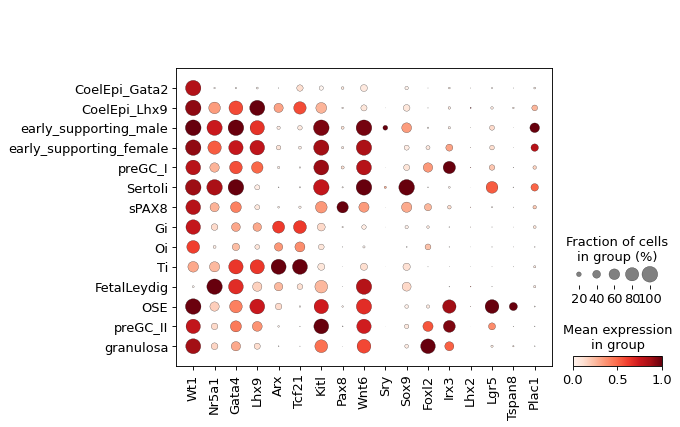

In [19]:
sc.pl.dotplot(adata, ['Wt1', 'Nr5a1', 'Gata4', 'Lhx9', 'Arx',  'Tcf21', 'Kitl', 'Pax8',  'Wnt6', 'Sry', 'Sox9', 'Foxl2', 'Irx3', 'Lhx2', 'Lgr5', 'Tspan8', 'Plac1'], groupby='celltype2', standard_scale = 'var')

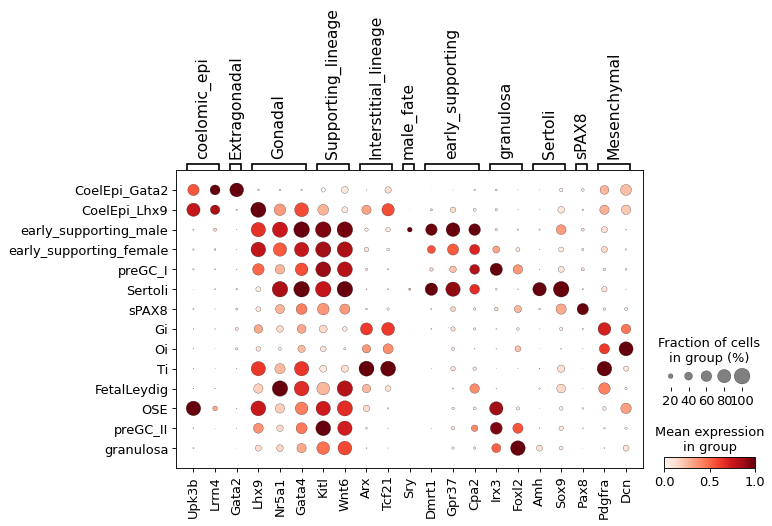

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


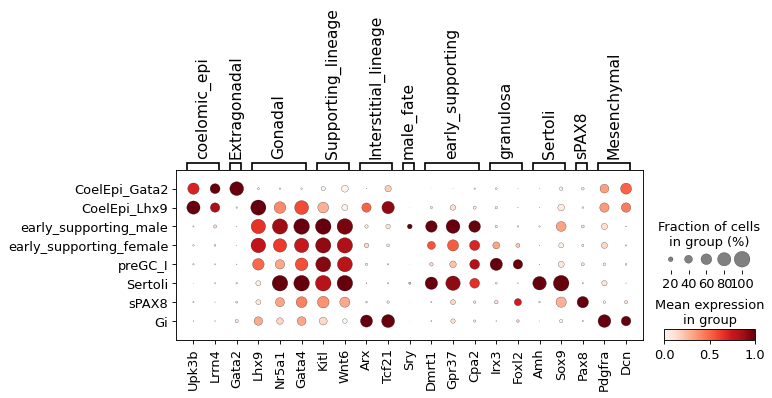

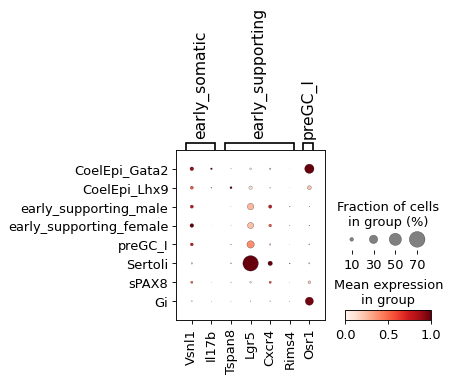

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


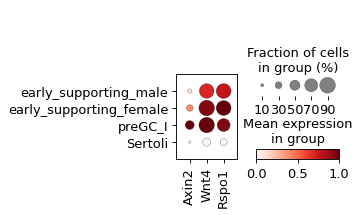

In [20]:
marker_genes_shared1wave = {
    'coelomic_epi': {'Lrrn4', 'Upk3b'},
    'Extragonadal':{'Gata2'},
    'Gonadal':{'Lhx9', 'Gata4', 'Nr5a1'},
    'Supporting_lineage':{"Wnt6",  'Kitl'},
    'Interstitial_lineage':{'Arx', 'Tcf21'},
    'male_fate':{'Sry'},
    'early_supporting':{'Cpa2', 'Gpr37', 'Dmrt1'},
    'granulosa':{'Foxl2', "Irx3"},
    'Sertoli': {'Amh','Sox9'},
    'sPAX8':{'Pax8'},
    'Mesenchymal':{'Dcn', 'Pdgfra'}
}
marker_genes_humanspecific  = {
    'early_somatic': {'Il17b', 'Vsnl1'},
    'early_supporting':{'Lgr5', 'Tspan8', 'Cxcr4', 'Rims4'},
    'preGC_I':{'Osr1'}
}

sc.pl.dotplot(adata, marker_genes_shared1wave, groupby='celltype2', standard_scale = 'var')
x = adata[[ i not in ['Oi', 'Ti', 'FetalLeydig', 'OSE', 'granulosa', 'preGC_II'] for i in adata.obs.celltype ]]
sc.pl.dotplot(x, marker_genes_shared1wave, groupby='celltype2', standard_scale = 'var', save='_mouse_marker_dynamics.pdf')
sc.pl.dotplot(x, marker_genes_humanspecific, groupby='celltype2', standard_scale = 'var', save='_mouse_marker_dynamics_humansspecific.pdf')
sc.pl.dotplot(x[[ i in ['Sertoli', 'early_supporting', 'preGC_I'] for i in x.obs.celltype ]], ['Axin2', 'Wnt4', 'Rspo1'], groupby='celltype2', standard_scale = 'var', save='_mouse_femaleFate_markers.pdf')


## PLOT second wave GRANULOSA

In [21]:
marker_genes_shared1wave = {
    'coelomic_epi': {'Lrrn4', 'Upk3b'},
    'Extragonadal':{'Gata2'},
    'Gonadal':{'Lhx9', 'Gata4', 'Nr5a1'},
    'Supporting_lineage':{"Wnt6",  'Kitl'},
    'Interstitial_lineage':{'Arx', 'Tcf21'},
    'male_fate':{'Sry'},
    'early_supporting':{'Lgr5', 'Cpa2', 'Gpr37', 'Dmrt1'},
    'granulosa':{'Foxl2', "Irx3"},
    'Sertoli': {'Amh','Sox9'},
    'sPAX8':{'Pax8'},
    'Mesenchymal':{'Dcn', 'Pdgfra'}
}

marker_genes_granulosa  = {
    'Mesothelial': {'Lrrn4', 'Upk3b'},
    'Gonadal':{'Lhx9', 'Gata4'},
    'granulosa_fate':{'Foxl2'},
    'early_supporting':{'Tspan8', 'Lgr5'},
    'preGC_I':{'Osr1', 'Plac1'},
    'preGC_I_':{'Cyp19a1'},
    'OSE':{'Calb2'},
    '2nd_wave':{'Lhx2', "Irx3"},
    'preGC_IIa':{"Cyp26b1"},
    'preGC_IIb':{'Bmp2'},
    'granulosa':{"Notch3","Rdh10"}
}

In [22]:
set(x.obs['celltype'])

{'CoelEpi_Gata2',
 'CoelEpi_Lhx9',
 'Gi',
 'Sertoli',
 'early_supporting',
 'preGC_I',
 'sPAX8'}

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


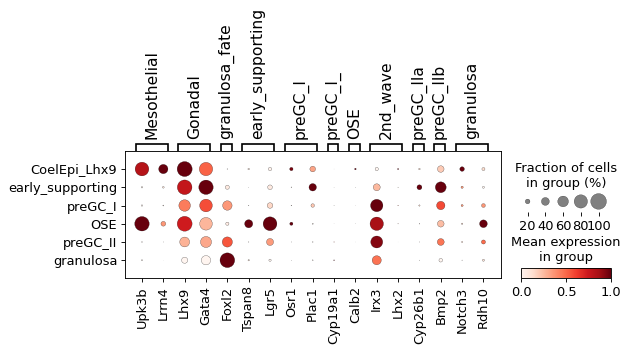

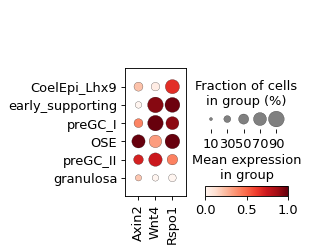

In [23]:
# granulosa
x = adata[[ i in ['CoelEpi_Lhx9', 'early_supporting', 'preGC_I', 'OSE', 'granulosa', 'preGC_II'] for i in adata.obs.celltype ]]
x = x[[ 'female' in i for i in x.obs.sex ]]

x.obs['celltype'].cat.reorder_categories(['CoelEpi_Lhx9',  'early_supporting', 'preGC_I', 
                                              'OSE', 'preGC_II','granulosa'], inplace=True)
sc.pl.dotplot(x, marker_genes_granulosa, groupby='celltype', standard_scale = 'var', save='_mouse_granulosa_markers.pdf')
sc.pl.dotplot(x, ['Axin2', 'Wnt4', 'Rspo1'], groupby='celltype', standard_scale = 'var', save='_mouse_granulosa_WNTpathway_markers.pdf')

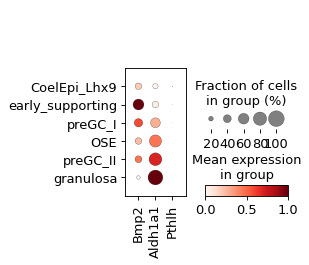

In [24]:
sc.pl.dotplot(x, ['Bmp2', 'Aldh1a1', 'Pthlh'], groupby='celltype', standard_scale = 'var')

In [25]:
import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [26]:
df = adata.obs
mycolors =  adata.uns['celltype_colors']

In [27]:
%%R -i df -i mycolors

library(ggplot2)
df$time_range = df$stage_merged
df$sex = as.character(df$sex)
df$sex[ df$stage_merged  == 'E10.5' ] = 'bipotent'
df$sex = factor(df$sex, levels = c('bipotent', 'male', 'female') )


idx = df$celltype == 'Ti' & df$sex == 'female'
df = subset(df, ! idx )
idx = df$celltype == 'Sertoli' & df$sex == 'female'
df = subset(df, ! idx )
idx = df$celltype == 'OSE' & df$sex == 'male'
df = subset(df, ! idx )
idx = df$celltype == 'Oi' & df$sex == 'male'
df = subset(df, ! idx )
idx = df$celltype == 'preGC_IIa' & df$sex == 'male'
df = subset(df, ! idx )

ggplot(df, aes(x=time_range, fill = celltype) ) + 
    scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
    geom_bar(position = 'fill')+
    theme_classic(15) + theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    ylab('fraction cells')+
    xlab('gestational stage')
ggsave(filename = paste0('figures_somatic/barplot_celltype_per_sex_fine_highres.pdf'), dpi = 300, width = 8, height = 4.5)

ggplot(df, aes(x=time_range, fill = celltype) ) + 
    scale_fill_manual(values = mycolors) +
    geom_bar(position = 'fill')+
    theme_classic(15) + theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    ylab('fraction cells')+
    xlab('gestational stage')
ggsave(filename = paste0('figures_somatic/barplot_celltype_fine_highres.pdf'), dpi = 300, width = 5, height = 4.5)

## Plot cellphoneDB genes

In [28]:
%%R -o orthologous
# load orthologous
orthologous = read.csv('/nfs/team292/vl6/Mouse_Niu2020/biomart_human_mouse_orthologs.tsv', stringsAsFactors = F, sep ='\t')
# Remove duplicates prioritizing gene match
orthologous$match = (toupper(orthologous$Mouse.gene.name) == orthologous$Gene.name) * 1
orthologous = orthologous[ order(orthologous$match, decreasing = T),  ]
orthologous = orthologous[ ! duplicated(orthologous$Mouse.gene.name),  ]
orthologous = orthologous[ ! duplicated(orthologous$Gene.name),  ]
rownames(orthologous) = orthologous$Gene.name

In [29]:
orthologous_dict = orthologous['Mouse.gene.name'].to_dict()

In [30]:
cellphoneDB_genes = {
    'cortex':{'BMP4','IGF1','PTGER3',  'PDGFRA','ADRA2A','ADRB3','EPHA4','EFNB2','EFNB3', 'CXCR4', 'KITLG', 'NRG1', 'NOTCH2'},
    'medulla':{'NOTCH2', 'ESR1', 'CYP19A1', 'HSD17B1', 'AR','ACVR2B', 'BMPR1B','BMP2' ,
                     'STRA6', 'PTHLH' , 'ALDH1A1', 'EFNB1', 'NR1H4'},
    'follicle':{'BMPR2', 'BMPR1B', 'ACVR2B', 'TGFBR1', 'NOTCH1','NOTCH2', 'NOTCH3', 'CD46', 'HRH1', 'ERBB4', 'RARRES2', 'EGFR', 'NTN1'}
}

In [31]:
cellphoneDB_genes_sorted = []

for group in cellphoneDB_genes.keys():
    cellphoneDB_genes[group] = [ orthologous_dict[i] for i in cellphoneDB_genes[group] if i in orthologous_dict.keys()]
    cellphoneDB_genes[group] = [ i for i in cellphoneDB_genes[group] if i in x.var_names ]
    cellphoneDB_genes[group] = sorted(cellphoneDB_genes[group])
    
    
genes = [item for sublist in cellphoneDB_genes.values() for item in sublist]

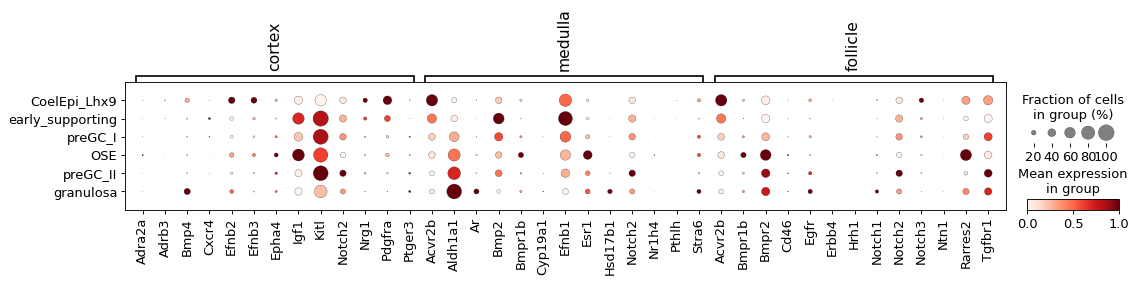

In [32]:
sc.pl.dotplot(x, cellphoneDB_genes, groupby='celltype', standard_scale = 'var', save='_mouse_cellphoneDB_genes.pdf')

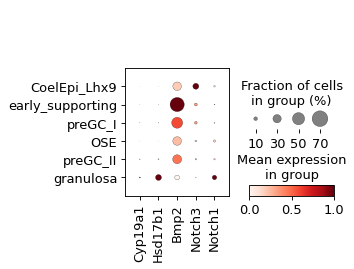

In [33]:
sc.pl.dotplot(x, ['Cyp19a1', 'Hsd17b1', 'Bmp2', 'Notch3', 'Notch1'], groupby='celltype', standard_scale = 'var', save='_mouse_2wavesignalling.pdf')

# Plots for reviewers

### SRY peak

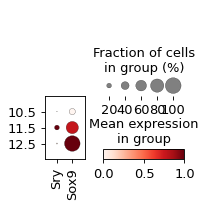

In [42]:
xx = adata[[ i in ['early_supporting', 'Sertoli'] for i in adata.obs.celltype  ]]
xx = xx[[ 'female' not in i for i in xx.obs.sex  ]]

sc.pl.dotplot(xx, ['Sry', 'Sox9'], groupby='stage', standard_scale = 'var', save='_mouse_2wavesignalling.pdf')